In [1]:
from ase.io import read
from ase.data import atomic_numbers
from ase import Atoms
import numpy as np
import pandas as pd
from dscribe.descriptors import SineMatrix
from gaussian_process import Gaussian_Process, Path_Tracker, Multi_Gauss_Kernel
from optimizers import HMC, conj_gradient
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_json('../datasets/train.json')
test = pd.read_json('../datasets/test.json')

In [3]:
import numpy as np

def pca(X, prec = 1e-10, num = None):
    """
    Perform Principal Component Analysis (PCA) on the dataset X.

    Parameters:
        X (numpy.ndarray): Input data matrix with shape (n_samples, n_features).
        num_components (int): Number of principal components to compute.

    Returns:
        numpy.ndarray: Transformed dataset with shape (n_samples, num_components).
        numpy.ndarray: Principal components (eigenvectors) with shape (n_features, num_components).
        numpy.ndarray: Explained variances corresponding to the principal components.
    """
    # Step 1: Mean center the data
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean

    # Step 2: Compute the covariance matrix
    covariance_matrix = np.cov(X_centered, rowvar=False)
    
    # Step 3: Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Step 4: Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Step 5: Determine components needed
    if num is not None:
        num_components = num
    else:
        sum_vals = sum(eigenvalues)
        prim_val = 0.0
        for i in range(len(eigenvalues)):
            prim_val += eigenvalues[i]
            num_components = i
            if (1 - prim_val/sum_vals) < prec:
                print("Accuracy: ", (1 - prim_val/sum_vals))
                break
    
    principal_components = eigenvectors[:, :num_components]

    # Step 6: Transform the data
    X_transformed = np.dot(X_centered, principal_components)

    return X_transformed, principal_components, num_components, X_mean

In [4]:
atomic_symbols = {val : key for key, val in atomic_numbers.items()}
atoms_generate = train.atoms[0].copy()

def make_atoms(atoms_dict):
    tempdict = atoms_dict.copy()
    tempdict['symbols'] = [atomic_symbols[number] for number in atoms_dict['numbers']]
    del tempdict['numbers']
    return Atoms(**tempdict)

atom_test = make_atoms(train.atoms[0])

In [40]:
maxlen = np.max([len(atom['numbers']) for atom in train.atoms])
sm = SineMatrix(
    n_atoms_max=maxlen,
    permutation="sorted_l2",
    sparse=False
)
fingerprints_ordered = np.array([sm.create(make_atoms(atom)).flatten() for atom in train.atoms])
rng = np.random.default_rng(40)
perm = rng.permutation(len(fingerprints_ordered))
fingerprints_unnormalized = fingerprints_ordered[perm]
values = train.hform[perm]
finger_norm = np.max(abs(fingerprints_unnormalized), axis = 0)
fingerprints = fingerprints_unnormalized/finger_norm

In [42]:
X_red, trans, num, Xmean = pca(fingerprints, prec = 1e-1)
print('Number of features: ', num)

Accuracy:  0.09910187847560392
Number of features:  33


In [46]:
xdat = X_red[:200]
tdat = values[:200]

## Single-spread

### Conjugate gradient

In [47]:
GP_Conj = Gaussian_Process(x_dat = xdat, t_dat = tdat, hyper_par = [1.0, 1.0], noise = 1e-2)
path = Path_Tracker()

par, neglog, iter = GP_Conj.optimize_par(conj_gradient, nsteps = 10, path = path, prec = 1e-8)
opt_par = path.get_prediction()
iter

Text(0.5, 0, '$\\sigma$')

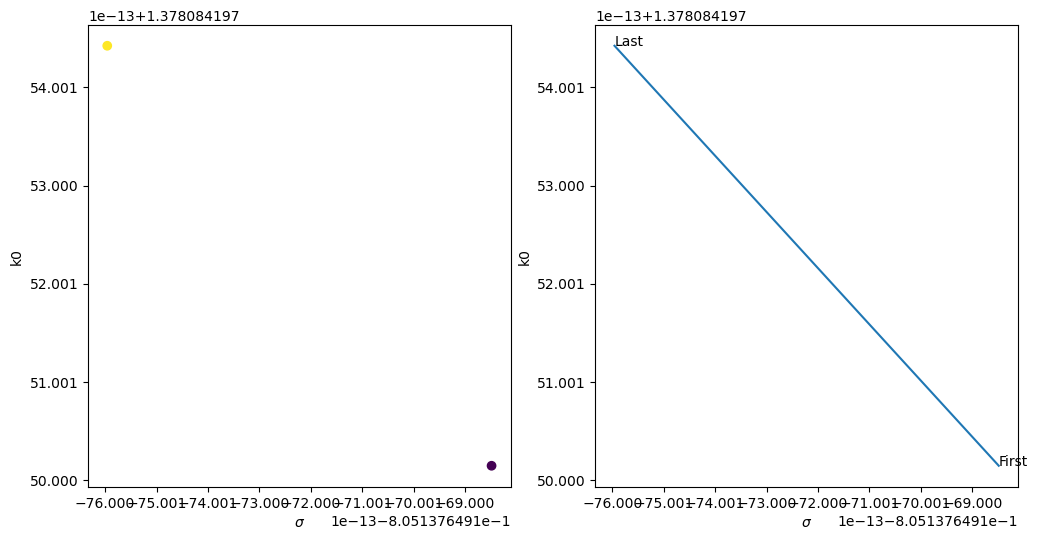

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
plot_x = np.array(path.x_steps)[:,0]
plot_y = np.array(path.x_steps)[:,1]
ax1.scatter(plot_x, plot_y, c = path.likelihood)
ax2.text(*(path.x_steps[0]), 'First')
ax2.text(*(path.x_steps[-1]), 'Last')
ax2.plot(plot_x, plot_y)
ax1.set_ylabel('k0')
ax2.set_ylabel('k0')
ax1.set_xlabel('$\sigma$')
ax2.set_xlabel('$\sigma$')

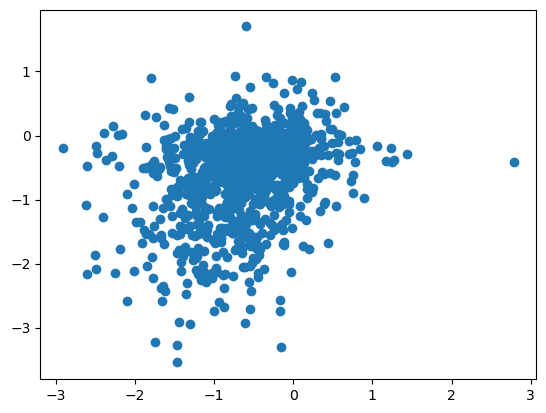

In [49]:
xpred = X_red[1000:2000]
vals = values[1000:2000]
GP_res_Conj = Gaussian_Process(hyper_par = opt_par, noise = 1e-1)
GP_res_Conj.calculate(xdat, tdat)
pred = GP_res_Conj.predict(xpred)
plt.scatter(pred, vals)

### HMC

In [ ]:
GP_HMC = Gaussian_Process(x_dat = xdat, t_dat = tdat, hyper_par = [1.0, 1.0], noise = 1e-1)
path_HMC = Path_Tracker()

par, neglog, iter = GP_HMC.optimize_par(HMC, mass = 2, sigma = 1, nsteps = 20, n_integrate = 10, path = path_HMC)
opt_par = path_HMC.get_prediction()
GP_res_HMC = Gaussian_Process(hyper_par = opt_par, noise = 1e-2)
GP_res_HMC.calculate(xdat, tdat)
print(opt_par)

20% 25% [-0.89177676  1.46008309]


Text(0.5, 0, '$\\sigma$')

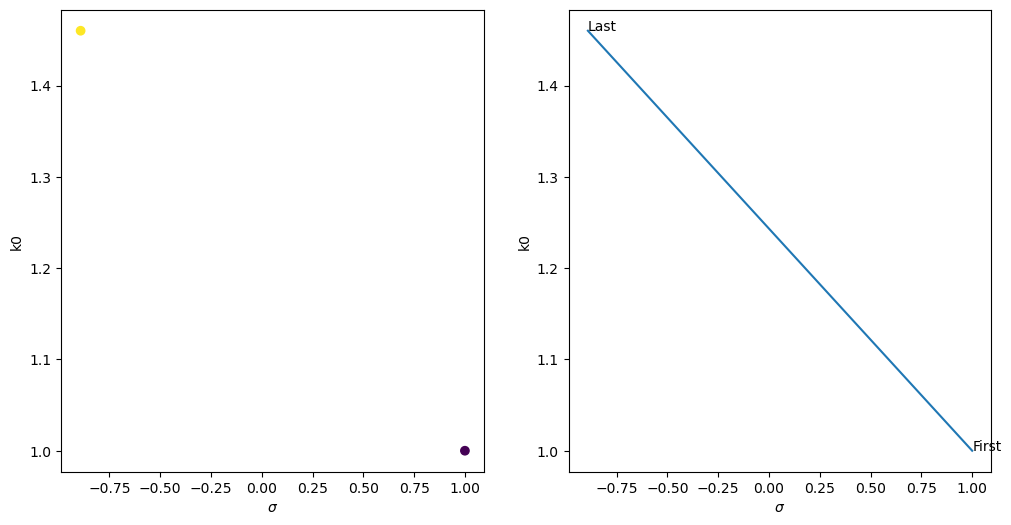

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
plot_x = np.array(path_HMC.x_steps)[:,0]
plot_y = np.array(path_HMC.x_steps)[:,1]
ax1.scatter(plot_x, plot_y, c = path_HMC.likelihood)
ax2.text(*(path_HMC.x_steps[0]), 'First')
ax2.text(*(path_HMC.x_steps[-1]), 'Last')
ax2.plot(plot_x, plot_y)
ax1.set_ylabel('k0')
ax2.set_ylabel('k0')
ax1.set_xlabel('$\sigma$')
ax2.set_xlabel('$\sigma$')

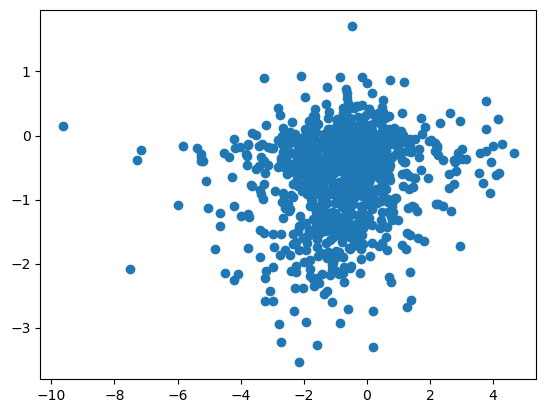

In [57]:
xpred = X_red[1000:2000]
vals = values[1000:2000]
pred = GP_res_HMC.predict(xpred)
plt.scatter(pred, vals)

## Multi-spread

### Conjugate gradient

In [16]:
init_par = [100] + list(np.sqrt(np.mean(X_red**2, axis = 0)))
init_par

[100,
 8890.7755371381,
 4839.171523654493,
 2855.473281756745,
 2591.1029218719013,
 1586.1964390148514,
 1374.8142258670348,
 1034.7518101644907,
 698.8492411406276,
 555.4457168238198,
 478.77993241809065,
 448.613316826544,
 418.80474566478125,
 338.09810754713254]

In [11]:
GP_Conj = Gaussian_Process(x_dat = xdat, t_dat = tdat, kernel = Multi_Gauss_Kernel(), hyper_par = init_par, noise = 1e-1)
path = Path_Tracker()

par, neglog, iter = GP_Conj.optimize_par(conj_gradient, nsteps = 100, path = path)
opt_par = path.get_prediction()
print(iter)

Text(0.5, 0, '$\\sigma$')

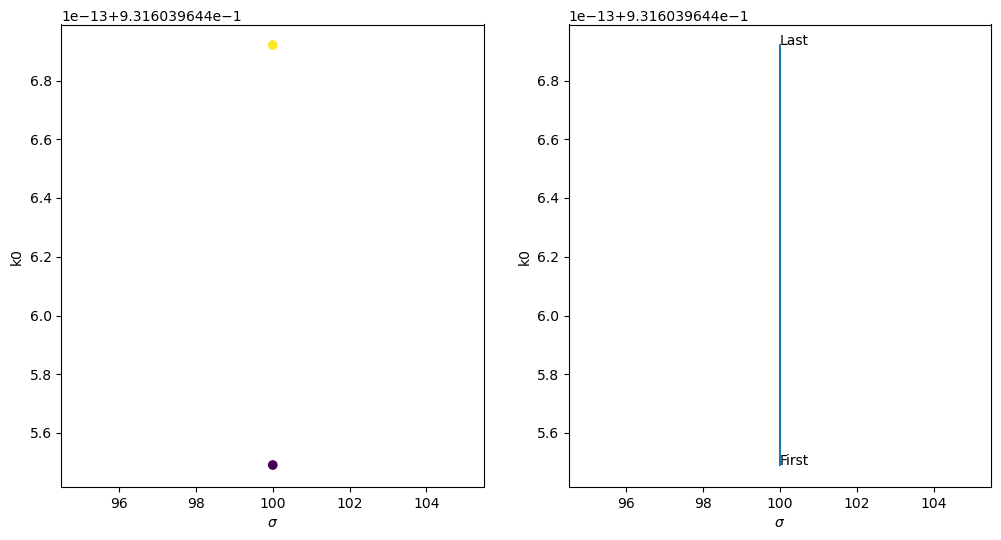

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
plot_x = np.array(path.x_steps)[:,0]
plot_y = np.array(path.x_steps)[:,1]
ax1.scatter(plot_x, plot_y, c = path.likelihood)
ax2.text(*(path.x_steps[0]), 'First')
ax2.text(*(path.x_steps[-1]), 'Last')
ax2.plot(plot_x, plot_y)
ax1.set_ylabel('k0')
ax2.set_ylabel('k0')
ax1.set_xlabel('$\sigma$')
ax2.set_xlabel('$\sigma$')

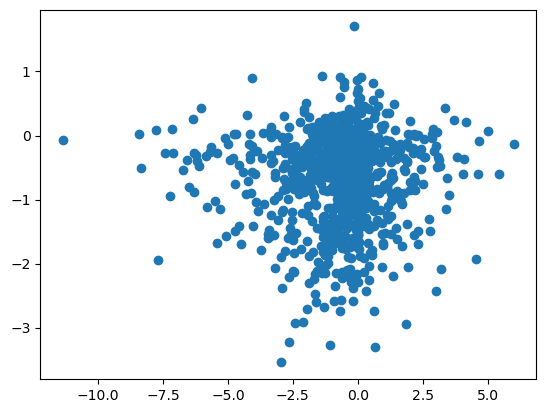

In [13]:
xpred = X_red[1000:2000]
vals = values[1000:2000]
GP_res_Conj = Gaussian_Process(kernel = Multi_Gauss_Kernel(),hyper_par = opt_par, noise = 1e-1)
GP_res_Conj.calculate(xdat, tdat)
pred = GP_res_Conj.predict(xpred)
plt.scatter(pred, vals)

### HMC

In [9]:
GP_HMC = Gaussian_Process(kernel = Multi_Gauss_Kernel(), x_dat = xdat, t_dat = tdat, hyper_par = init_par, noise = 1e-1)
path_HMC = Path_Tracker()
par, neglog, iter = GP_HMC.optimize_par(HMC, mass = 1, sigma = 1, nsteps = 10, n_integrate = 5, path = path_HMC)
opt_par = path_HMC.get_prediction()
GP_res_HMC = Gaussian_Process(kernel = Multi_Gauss_Kernel(), hyper_par = opt_par, noise = 1e-1)
GP_res_HMC.calculate(xdat, tdat)
print(opt_par)

60% 90% [  91.83804405 8886.32655877 4844.2334327  2853.19666458 2594.6475391
 1585.228832   1372.80982015 1029.48462574  697.99426399  547.65799575
  482.37039214  439.82359059  418.91244047  343.69910039]


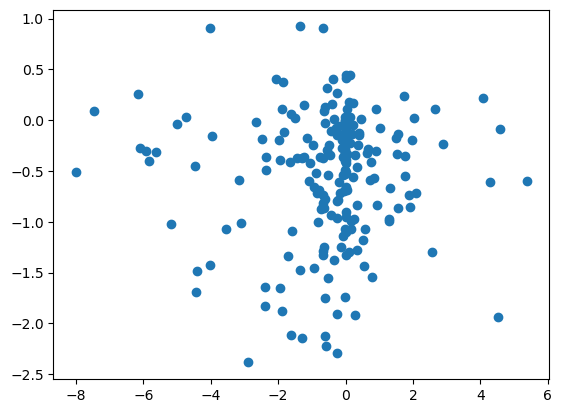

In [10]:
xpred = X_red[1200:1400]
vals = values[1200:1400]
pred = GP_res_HMC.predict(xpred)
plt.scatter(pred, vals)